In [19]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import QuantileTransformer as Transformer
# from sklearn.preprocessing import StandardScaler as Transformer
from sklearn.model_selection import train_test_split
from torch import nn
import torch

In [20]:
def read_fvecs(file_name):
    a = np.fromfile(file_name, dtype="int32")
    dim = a[0]
    return a.view("float32").reshape((-1, dim + 1))[:,1:]

In [21]:
def clone_model(model):
    torch.save(model, "tmp/tmp_model.net")
    return torch.load("tmp/tmp_model.net")

In [22]:
DATASET = "collections"
EMBEDDING_DIM = 50
HIDDEN_DIM = 128

ITEM_BATCH_SIZE = 100
QUERY_BATCH_SIZE = 100
CLOSE_ITEM_COUNT = 10000 # should be <= 10000

In [23]:
item_features = read_fvecs("{}/data/item_features.fvecs".format(DATASET))
train_query_features = read_fvecs("{}/data/user_features_train.fvecs".format(DATASET))
test_query_features = read_fvecs("{}/data/user_features_test.fvecs".format(DATASET))

In [24]:
# def measure_scattering(data):
#     scattering = data.max(axis=0) - data.min(axis=0)
#     scattering /= data.std(axis=0)
#     return scattering

In [25]:
ITEM_COUNT, ITEM_FEATURES_COUNT = item_features.shape
QUERY_COUNT, QUERY_FEATURES_COUNT = train_query_features.shape
VALIDATION_QUERY_COUNT = 100
TRAIN_QUERY_COUNT = QUERY_COUNT - VALIDATION_QUERY_COUNT

train_query_indexes, val_query_indexes = train_test_split(
    np.arange(QUERY_COUNT), test_size=VALIDATION_QUERY_COUNT,
    random_state=0
)

In [29]:
target = np.fromfile(
    "{}/data/model_scores/scores_train.bin".format(DATASET),
    dtype="float32"
).reshape((ITEM_COUNT, QUERY_COUNT))
target = torch.FloatTensor(target)

In [ ]:
close_items = np.fromfile(
    "{}/data/model_scores/groundtruth_train_10000.bin".format(DATASET),
    dtype="int32"
).reshape(QUERY_COUNT, 10000)
close_items = close_items[:, :CLOSE_ITEM_COUNT]
close_probs = 1. / np.arange(1, CLOSE_ITEM_COUNT + 1)
close_probs /= close_probs.sum()


In [27]:
item_scaler = Transformer()
item_features = item_scaler.fit_transform(item_features)

query_scaler = Transformer()
train_query_features = query_scaler.fit_transform(train_query_features)
test_query_features = query_scaler.transform(test_query_features)

In [28]:
item_features = torch.FloatTensor(item_features)
train_query_features = torch.FloatTensor(train_query_features)
test_query_features = torch.FloatTensor(test_query_features)

In [40]:
item_net = nn.Sequential(
    nn.Linear(in_features=ITEM_FEATURES_COUNT, out_features=HIDDEN_DIM, bias=True),
    nn.BatchNorm1d(HIDDEN_DIM),
    nn.ELU(),
    nn.Linear(in_features=HIDDEN_DIM, out_features=HIDDEN_DIM, bias=True),
    nn.BatchNorm1d(HIDDEN_DIM),
    nn.ELU(),
    nn.Linear(in_features=HIDDEN_DIM, out_features=EMBEDDING_DIM, bias=True),
)

query_net = nn.Sequential(
    nn.Linear(in_features=QUERY_FEATURES_COUNT, out_features=HIDDEN_DIM, bias=True),
    nn.BatchNorm1d(HIDDEN_DIM),
    nn.ELU(),
    nn.Linear(in_features=HIDDEN_DIM, out_features=HIDDEN_DIM, bias=True),
    nn.BatchNorm1d(HIDDEN_DIM),
    nn.ELU(),
    nn.Linear(in_features=HIDDEN_DIM, out_features=EMBEDDING_DIM, bias=True),
)


optimizer = torch.optim.Adam(
    params=list(item_net.parameters()) + list(query_net.parameters()),
#     lr=0.01, weight_decay=0.1
)
# optimizer = torch.optim.SGD(
#     params=list(item_net.parameters()) + list(query_net.parameters()),
#     lr=0.001, weight_decay=0.1
# )
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5)

item_model_path = "collections/item.net"
query_model_path = "collections/query.net"
best_loss = None
best_epoch = 0
curr_epoch = 0
logs = {
    "train": [],
    "validation": []
}

In [41]:
def calc_batch_loss_stupid(query_indexes, train=True):
    batch_queries = train_query_features[query_indexes]
    
    batch_item_indexes = np.random.choice(ITEM_COUNT, ITEM_BATCH_SIZE, replace=False)
    batch_items = item_features[batch_item_indexes]
    batch_target = target[batch_item_indexes][:,query_indexes]

    if train:
        item_net.train()
        query_net.train()
    else:
        item_net.eval()
        query_net.eval()

    batch_item_embeds = item_net(batch_items)
    batch_query_embeds = query_net(batch_queries)
    relevance_prediction = torch.matmul(batch_item_embeds, batch_query_embeds.T)
    loss = ((batch_target - relevance_prediction) ** 2).mean()
    return loss

def calc_batch_loss(query_indexes, train=True):
    batch_queries = train_query_features[query_indexes]
    
    positives_ranks = np.random.choice(
        CLOSE_ITEM_COUNT, len(query_indexes), p=close_probs)
    positives_indexes = close_items[query_indexes, positives_ranks]
    batch_posives = item_features[positives_indexes]
    positive_target = target[positives_indexes, query_indexes]

    negative_indexes = np.random.choice(ITEM_COUNT, ITEM_BATCH_SIZE, replace=False)
    batch_negatives = item_features[negative_indexes]
    negative_target = target[negative_indexes][:,query_indexes]

    if train:
        item_net.train()
        query_net.train()
    else:
        item_net.eval()
        query_net.eval()

    batch_query_embeds = query_net(batch_queries)
    
    positive_item_embeds = item_net(batch_posives)
    positive_relevance_prediction = (positive_item_embeds * batch_query_embeds).sum(axis=1)
    positive_loss = ((positive_target - positive_relevance_prediction) ** 2).mean()
    
    negative_item_embeds = item_net(batch_negatives)
    negative_relevance_prediction = torch.matmul(negative_item_embeds, batch_query_embeds.T)
    negative_loss = ((negative_target - negative_relevance_prediction) ** 2).mean()
    return positive_loss + negative_loss

In [42]:
PASSES_PER_EPOCH = 10

# new_lr = 0.001
# new_decay = 0.1
# momentum = 0.9
# for param_group in optimizer.param_groups:
#     param_group['lr'] = new_lr
#     param_group['weight_decay'] = new_decay
#     param_group['momentum'] = momentum

In [43]:
for local_epoch_num in range(90):
    train_loss = 0
    validation_loss = 0
    
    for i in range(PASSES_PER_EPOCH):
        query_permutation = np.random.permutation(train_query_indexes)
        for batch_start in range(0, TRAIN_QUERY_COUNT, QUERY_BATCH_SIZE):
            batch_query_indexes = query_permutation[batch_start: batch_start + QUERY_BATCH_SIZE]
            loss = calc_batch_loss_stupid(batch_query_indexes)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()
    train_loss /= TRAIN_QUERY_COUNT * PASSES_PER_EPOCH
    logs["train"].append(train_loss)
    for i in range(PASSES_PER_EPOCH):
        validation_loss += calc_batch_loss_stupid(
            val_query_indexes, train=False).data.item()
    validation_loss /= VALIDATION_QUERY_COUNT * PASSES_PER_EPOCH
    logs["validation"].append(validation_loss)
    scheduler.step(validation_loss)
    if best_loss is None or validation_loss < best_loss:
        best_loss = validation_loss
        best_epoch = curr_epoch
        torch.save(item_net, item_model_path)
        torch.save(query_net, query_model_path)
    
    print("{:>4} Train loss: {:<30.5} Validation loss: {:<30.5} {:.6}".format(
        curr_epoch, train_loss, validation_loss, optimizer.param_groups[0]["lr"]))
#     if curr_epoch > best_epoch + 10:
#         break
    curr_epoch += 1

   0 Train loss: 0.0092321                      Validation loss: 0.0067041                      0.001
   1 Train loss: 0.0063846                      Validation loss: 0.0063347                      0.001
   2 Train loss: 0.0060433                      Validation loss: 0.0060445                      0.001
   3 Train loss: 0.0059534                      Validation loss: 0.0059335                      0.001
   4 Train loss: 0.0058429                      Validation loss: 0.0062284                      0.001
   5 Train loss: 0.0057897                      Validation loss: 0.0060093                      0.001
   6 Train loss: 0.0056666                      Validation loss: 0.0056715                      0.001
   7 Train loss: 0.0056463                      Validation loss: 0.0059128                      0.001
   8 Train loss: 0.0055787                      Validation loss: 0.0058278                      0.001
   9 Train loss: 0.0055296                      Validation loss: 0.0063735        

KeyboardInterrupt: 

In [36]:
best_epoch, best_loss

(81, 0.005755041778087616)

In [72]:
best_epoch, best_loss

(87, 0.0595288667678833)

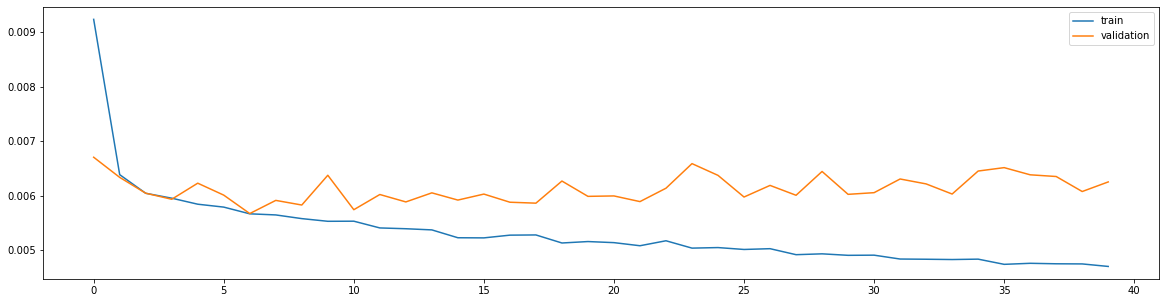

In [45]:
start = 0
plt.figure(figsize=(20, 5))
epochs = list(range(start, len(logs["train"])))
plt.plot(epochs, logs["train"][start:], label = "train")
plt.plot(epochs, logs["validation"][start:], label = "validation")
plt.legend()
plt.show()

In [18]:
item_net = torch.load(item_model_path)
query_net = torch.load(query_model_path)

In [74]:
best_item_net = torch.load(item_model_path)
best_query_net = torch.load(query_model_path)
pref = "dssm_i128_q128_close_items"
torch.save(best_item_net, "{}/{}_item.net".format(DATASET, pref))
torch.save(best_query_net, "{}/{}_query.net".format(DATASET, pref))

In [75]:
best_item_net.eval()
best_query_net.eval()

item_embeddings = best_item_net(item_features).detach().numpy()
item_embeddings.astype("float32").tofile("{}/data/item_embeddings.bin".format(DATASET))

train_query_embeddings = best_query_net(train_query_features).detach().numpy()
train_query_embeddings.astype("float32").tofile("{}/data/query_embeddings_train.bin".format(DATASET))

test_query_embeddings = best_query_net(test_query_features).detach().numpy()
test_query_embeddings.astype("float32").tofile("{}/data/query_embeddings_test.bin".format(DATASET))

embedding_train_scores = item_embeddings.dot(train_query_embeddings.T)
embedding_train_scores.astype("float32").tofile(
    "{}/data/model_scores/embedding_scores_train.bin".format(DATASET)
)
del embedding_train_scores

embedding_test_scores = item_embeddings.dot(test_query_embeddings.T)
embedding_test_scores.astype("float32").tofile(
    "{}/data/model_scores/embedding_scores_test.bin".format(DATASET)
)
del embedding_test_scores